# 1. Introduction
For this project, we will be analyzing the results of an A/B test run by an e-commerce website. The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

# 2. Import data & data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df=pd.read_csv('/kaggle/input/ab-data/sample ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check for mismatches: Ensure that each user in the control group is only seeing the old page and users in the treatment group are seeing the new page.

In [4]:
((df.group=='treatment') & (df.landing_page=='old_page')).sum()

1965

In [5]:
((df.group=='control') & (df.landing_page=='new_page')).sum()

1928

In [6]:
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))
df = df[-df['misaligned']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


In [8]:
df.head()

,user_id,timestamp,group,landing_page,converted,misaligned
0,851104,11:48.6,control,old_page,0,False
1,804228,01:45.2,control,old_page,0,False
2,661590,55:06.2,treatment,new_page,1,False
3,853541,28:03.1,treatment,new_page,1,False
4,864975,52:26.2,control,old_page,1,False


**Check unique users**

In [9]:
df.user_id.nunique()

290584

In [10]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
773192    2
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

**Make assumption:**

In [11]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,37:58.8,treatment,new_page,1,False
2893,773192,55:59.6,treatment,new_page,0,False


In [12]:
df.drop(1899, axis = 0,inplace = True)

In [13]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
851104    1
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

**How many users in each group**

In [14]:
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


Summary statistics: Calculate conversion rates for both groups (control and treatment).

In [15]:
df.groupby('group')['converted'].agg(['mean', 'count', 'sum'])

,mean,count,sum
group,,,
control,0.120386,145274,17489
treatment,0.125353,145310,18215


# 3. Analyze Results

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type II error. So the hypothesis woule be:

null:  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  <=0

alternative:  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  >0

In [16]:
convert_old = df[df.group=='control'].converted.sum()
convert_new = df[df.group=='treatment'].converted.sum()
n_old = len(df[df.group=='control'].converted)
n_new= len(df[df.group=='treatment'].converted)

convert_old, convert_new, n_old, n_new

(17489, 18215, 145274, 145310)

In [17]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new},'Converts': {'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
Control,145274,17489,12.0%
Test,145310,18215,12.5%


# 3.1 Z-test in our way

In [18]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    std = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(std*(1-std)*(1/n1 + 1/n0))

In [19]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [20]:
z_value = z_test(p1,p0,n1,n0)
z_value

4.077481782861739

In [21]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)
p_value

2.276304781123617e-05

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  >0, the new page has higher conversion rate than the old page


# 3.2 Z-test in Statsmodels

In [22]:
import statsmodels.api as sm

In [23]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(4.077481782861739, 2.276304781118429e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  >0, the new page has higher conversion rate than the old page

# 4. EDA

In [24]:
df['timestamp']

0         11:48.6
1         01:45.2
2         55:06.2
3         28:03.1
4         52:26.2
           ...   
294473    28:38.6
294474    51:57.1
294475    45:03.4
294476    20:29.0
294477    40:24.5
Name: timestamp, Length: 290584, dtype: object

In [25]:
df['timestamp']=df['timestamp'].str.split(':').str[0].astype(int)

In [26]:
df['timestamp']

0         11
1          1
2         55
3         28
4         52
          ..
294473    28
294474    51
294475    45
294476    20
294477    40
Name: timestamp, Length: 290584, dtype: int64

In [27]:
df_time = df.groupby(['timestamp', 'group'])['converted'].mean().reset_index()
df_time['Conversion %'] = df_time['converted'].apply(lambda x: f"{np.round(x * 100, 2)}%")
df_time.head()

,timestamp,group,converted,Conversion %
0,0,control,0.118893,11.89%
1,0,treatment,0.122311,12.23%
2,1,control,0.128778,12.88%
3,1,treatment,0.116889,11.69%
4,2,control,0.119730,11.97%


In [28]:
df_pivot = df_time.pivot(index='timestamp', columns='group', values='Conversion %')
df_pivot.head()

group,control,treatment
timestamp,,
0,11.89%,12.23%
1,12.88%,11.69%
2,11.97%,12.78%
3,12.58%,13.11%
4,12.41%,11.08%


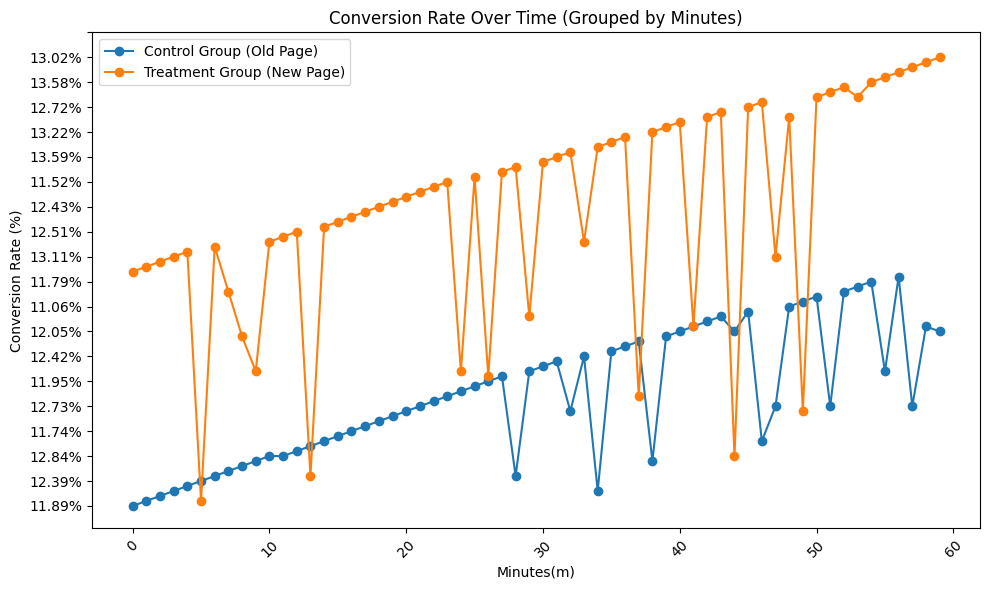

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df_pivot.index, df_pivot['control'], label='Control Group (Old Page)', marker='o')
plt.plot(df_pivot.index, df_pivot['treatment'], label='Treatment Group (New Page)', marker='o')


plt.title('Conversion Rate Over Time (Grouped by Minutes)')
plt.xlabel('Minutes(m)')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 100, 5))
plt.legend()

plt.tight_layout()
plt.show()